# Filter-and-Fire Neuron Model

## Background

This notebook provide an alternative filter-and-fire pytorch neuron model that might be easier and more robust to use.

In fact, we provide here an implementation of the Exp 3 that was introduced in Filter-and-Fire_Neuron_Model_SNN.ipynb, but wasn't implemented there.

### Experiments conducted (23.7.23)

Note: 
- M: number of connections per presynaptic axon

Main idea: Apply smoothing to the `presynaptic_input_spikes_tensor` to get PSP-like inputs, by convolving the original input spike trains with a normalised filter.

- Exp 1. M = 1
- Exp 2. M = 3 (Exp 3 of Filter-and-Fire_Neuron_Model_SNN.ipynb)

## Imports

In [1]:
!pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
from scipy import signal

from tqdm.auto import tqdm as pbar

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

## Hyperparameters

In [2]:
# Constants
SECOND = 1
MS = 1e-3
HZ = 1
PI = np.pi
DT = 1*MS # large time step to make simulations run faster

ANF_PER_EAR = 100    # repeats of each ear with independent noise (was 1000 in my other notebooks)
ENVELOPE_POWER = 2   # higher values make sharper envelopes, easier
RATE_MAX = 600*HZ   # maximum Poisson firing rate
F = 20*HZ           # stimulus frequency
DURATION = .1*SECOND # stimulus duration
DURATION_STEPS = int(np.round(DURATION/DT)) # 100
T = np.arange(DURATION_STEPS)*DT # array of times

# Network
INPUT_SIZE = 2*ANF_PER_EAR # 200 input neurons
NUM_HIDDEN = 30
NUM_CLASSES = 180//15 # classes at 15 degree increments
print('Number of classes = {}'.format(NUM_CLASSES))
TAU = 5*MS # this used to be 20 in the SNN Starting Notebook, is now 5 in Quick Start Notebook

# Training
MY_COMPUTER_IS_SLOW = True
if MY_COMPUTER_IS_SLOW:
    BATCH_SIZE = 64
    N_TRAINING_BATCHES = 64
else:
    BATCH_SIZE = 128
    N_TRAINING_BATCHES = 128
N_TESTING_BATCHES = 32
NUM_SAMPLES = BATCH_SIZE*N_TRAINING_BATCHES
BETA = 5 # for Surrogate Gradient Descent
NUM_EPOCHS = 100 # (takes ~6min/epoch with INPUT_SIZE=200)
LR = 0.0001

# Filter-and-Fire Neuron Model (Beniaguev et al., 2022)
NUM_AXONS = 100
CONNECTIONS_PER_AXON = 3
NUM_SYNAPSES = CONNECTIONS_PER_AXON * NUM_AXONS

Number of classes = 12


## Functions

### Stimulus

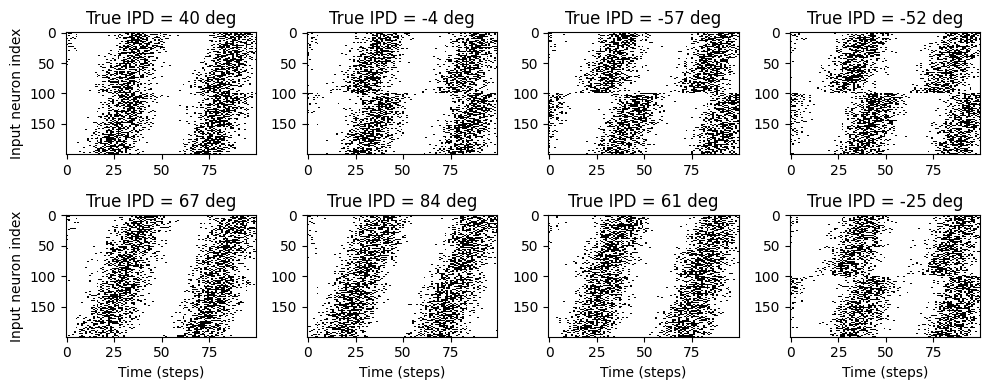

In [3]:
def input_signal(ipd, usual_phase_delays=True):
    """
    Generate an input signal (spike array) from array of true IPDs
  
    Parameters:
    ipd (array): true IPDs
  
    Returns:
    spikes (array): input signal from true IPDs (spike trains)
  
    """
    
    num_samples = len(ipd) # i.e., NUM_SAMPLES
    phi = 2*PI*(F*T+np.random.rand()) # array of phases corresponding to those times with random offset
 
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    if usual_phase_delays: # Exp 1., Exp 2.a
        phase_delays = np.linspace(0, PI/2, ANF_PER_EAR)
    else: # Exp 2.b, Exp 3.
        phase_delays = np.linspace(0, 0, ANF_PER_EAR)

    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<RATE_MAX*DT*(0.5*(1+np.sin(theta)))**ENVELOPE_POWER

    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, usual_phase_delays=True, tensor=True):
    """
    Generate the training data: true IPDs are in U(-pi/2, pi/2) 
  
    Parameters:
    num_samples (int)
    usual_phase_delays (boolean): flag on the use of usual or null phase delays
    tensor (boolean): flag on the use of tensor or numpy objects for the objects returned
  
    Returns:
    ipd (array): true IPDs from U(-pi/2, pi/2)
    spikes (array): input signal corresponding to the true IPDs in the training data
  
    """

    ipd = np.random.rand(num_samples)*PI-PI/2 # uniformly random in (-pi/2, pi/2)
    #print(ipd)# okay
    spikes = input_signal(ipd, usual_phase_delays)
    #print(spikes) # empty
    
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
        
    return ipd, spikes


def discretise(ipds):
    """
    Discretise the ipds in the training data 
  
    Parameters:
    ipds (tensor)
  
    Returns:
    tensor
  
    """
    return ((ipds+PI/2)*NUM_CLASSES/PI).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    """
    Undo the discretisation of ipds
  
    Parameters:
    ipd_indices (array)
  
    Returns:
    array
  
    """
    return (ipd_indices+0.5)/NUM_CLASSES*PI-PI/2


# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    """
    Generate the whole training data by iterating over the data in the batches.
    Order of the data is randomly permuted to improve learning.
  
    Parameters:
    ipds (tensor)
    spikes (tensor): flag on the use of usual or null phase delays
  
    Yields:
    x_local (tensor): relates to the spikes
    y_local (tensor): relates to the ipds
  
    """
    
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//BATCH_SIZE
    
    for i in range(n_batch):
        x_local = spikes[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        y_local = ipds[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        yield x_local, y_local

# Plot a few just to show how it looks
def plot_some_input_examples(num_examples=8):
    """
    Plots some example inputs.
  
    Parameters:
    num_examples (int): default = 8
  
    """
    
    ipd, spikes = random_ipd_input_signal(num_examples)
    spikes = spikes.cpu()
    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(num_examples):
        plt.subplot(2, 4, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/PI)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
        plt.tight_layout()
    
    
plot_some_input_examples()

### SNN

In [4]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*BETA*torch.sigmoid(BETA*input)*(1-torch.sigmoid(BETA*input))
        return grad

spike_fn  = SurrGradSpike.apply

# Run the simulation
def snn(presynaptic_input_spikes_tensor, W1, W1_bis, W2, 
        multiple_connections_per_axon, single_neuron_model):
    
    """
    Runs the SNN simulation.
  
    Parameters:
    presynaptic_input_spikes_tensor (tensor): corresponds to x_local in the training
    W1 (tensor): initialised trainable weight parameter for the first layer
    W2 (tensor): initialised trainable weight parameter for the second layer
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon,
    single_neuron_model (function): a function that computes the output of a single neuron, given input over multiple segments
  
    Returns:
    v_rec (tensor): recorded membrane potential of output
    input_smoothed (tensor): smoothed inputs
  
    """
    
    # First layer: input to hidden
    v = torch.zeros((BATCH_SIZE, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]

    cur_connections_per_axon = CONNECTIONS_PER_AXON if multiple_connections_per_axon else 1

    inputs_for_all_segments_of_all_hidden = (presynaptic_input_spikes_tensor @ W1)

    # BATCH_SIZE, DURATION_STEPS, NUM_HIDDEN * cur_connections_per_axon

    inputs_for_all_segments_of_all_hidden = inputs_for_all_segments_of_all_hidden.transpose(1,2)

    # BATCH_SIZE, NUM_HIDDEN * cur_connections_per_axon, DURATION_STEPS

    inputs_for_all_segments_of_all_hidden_for_single_neuron = inputs_for_all_segments_of_all_hidden.reshape(BATCH_SIZE * NUM_HIDDEN, cur_connections_per_axon, DURATION_STEPS)

    # BATCH_SIZE * NUM_HIDDEN, cur_connections_per_axon, DURATION_STEPS

    # we use a handy trick here, enlarging the batch size, so we can use a single neuron model for all the neurons in the hidden layer
    hidden_output = single_neuron_model(inputs_for_all_segments_of_all_hidden_for_single_neuron)

    # BATCH_SIZE * NUM_HIDDEN, DURATION_STEPS

    hidden_output = hidden_output.reshape(BATCH_SIZE, NUM_HIDDEN, DURATION_STEPS)
    
    s_rec = hidden_output.transpose(1,2)

    # Second layer: hidden to output
    v = torch.zeros((BATCH_SIZE, NUM_CLASSES), device=device, dtype=dtype)
    s = torch.zeros((BATCH_SIZE, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-DT/TAU)
    for t in range(DURATION_STEPS - 1):  
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    
    # Return recorded membrane potential of output and smoothed input (for visualisation)
    return v_rec

### Training

In [5]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    """
    Initialises the weight matrix used in the fanin-fanout calculations for the initialisation of W1 and W2.
  
    Parameters:
    None
    
    Returns:
    W (tensor): weight tensor used in fanin-fanout calculations
  
    """

    W = nn.Parameter(torch.empty((INPUT_SIZE, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    
    return W

def init_weight_matrices(W, multiple_connections_per_axon=False):
    """
    Initialises the weight matrices in the SNN: W1, W1_bis and W2.
  
    Parameters:
    W (tensor): weight tensor used in fanin-fanout calculations for W1 and W2
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
  
    Returns:
    W1 (tensor): initialised trainable weight parameter for the first layer
    W1_bis (tensor): fixed non-trainable weight parameter for the first layer when there are multiple connections per axon
    W2 (tensor): initialised trainable weight parameter for the second layer
  
    """
    
    if multiple_connections_per_axon: # Exp. 3
        # Input to hidden layer
        W1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN*CONNECTIONS_PER_AXON), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W1, -bound, bound)
    
        # placeholder for W1_bis (not used)
        W1_bis = torch.zeros(NUM_HIDDEN*CONNECTIONS_PER_AXON, NUM_HIDDEN)
    
        # Hidden layer to output
        W2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W2, -bound, bound)
        
    else:
        # Input to hidden layer
        W1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W1, -bound, bound)
        
        # placeholder for W1_bis (not used)
        W1_bis = torch.zeros(NUM_HIDDEN*CONNECTIONS_PER_AXON, NUM_HIDDEN)
    
        # Hidden layer to output
        W2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(W2, -bound, bound)
        
    return W1, W1_bis, W2
    
    
def train(ipds, spikes, usual_phase_delays=True, multiple_connections_per_axon=False, random_tau_constants=False, minimal_smoothing=False):
    """
    Runs the training of the SNN simulation.
  
    Parameters:
    usual_phase_delays (boolean): flag on the use of usual or null phase delays
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
  
    Returns:
    ipds (tensor): training data (y)
    spikes (tensor): training data (X)
    W1 (tensor): trained W1
    W2 (tensor): trained W2
    snn_training_snapshot (list): snapshots of the training at each epoch
  
    """
    
    # Generate the training data
    #ipds, spikes = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays)
    
    # Initialise weight matrices
    W = init_weight_matrix() # for fan_in/out calculations
    W1, W1_bis, W2 = init_weight_matrices(W, multiple_connections_per_axon)

    # Optimiser and loss function
    optimizer = torch.optim.Adam([W1, W2], lr=LR)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    snn_training_snapshot = []

    # TODO: plug all of these parameters inside: random_tau_constants, minimal_smoothing, currently they are being ignored
    single_neuron_model = FilterAndFireNeuron(count_segments=CONNECTIONS_PER_AXON if multiple_connections_per_axon else 1)
    
    for e in pbar(range(NUM_EPOCHS)):
        
        local_loss = []
        batch_number = 0
        
        print('--------------------------------------------------------')
        print("EPOCH {}".format(e+1))
        
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            
            batch_number += 1
            
            # Run network
            output = snn(x_local, W1, W1_bis, W2, multiple_connections_per_axon, single_neuron_model)
            
            # Compute cross entropy loss
            #m = torch.sum(output, 1)*0.01  # Sum time dimension
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension

            reg = 0 # to add regularisation later if wanted
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Record and print the loss of the current epoch
        loss_hist.append(np.mean(local_loss))
        print("---EPOCH %i: LOSS=%.5f"%(e+1, np.mean(local_loss)))

        # Plot raster plot: 
        # e.g. input_smoothed for the 1st example of the last batch of the current epoch
        #print("---Raster Plots at Epoch {} - Example #1/64 of the Last Batch Group".format(e+1))
        #plt.figure(1)
        #plt.title("input_smoothed example vs corresponding initial spike train")
        #plt.subplot(211)
        #plt.imshow(input_smoothed[0, :, :].detach().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        #plt.xlabel('Time (steps)')
        #plt.ylabel('Input neuron index')
        #plt.subplot(212)
        #plt.imshow(x_local[0, :, :].detach().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        #plt.xlabel('Time (steps)')
        #plt.ylabel('Input neuron index')
    
        #plt.show()
        
        # Take a snapshot of the model at the end of the current epoch. 
        ## Use cases:
        ### if we want to resume training from this current epoch,
        ### or if the training is halted before the last epoch
        snn_training_snapshot.append({'W1':W1, 'W2':W2, 
                                      'multiple_connections_per_axon':multiple_connections_per_axon, 
                                      'random_tau_constants':random_tau_constants, 
                                      'minimal_smoothing':minimal_smoothing}) 
        
    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    # return the train dataset (ipds, spikes) and trained weights for analysis
    # also return the list of model snapshots for each epoch (in case we want to resume training)
    return W1, W1_bis, W2, snn_training_snapshot, single_neuron_model


### Train and Test Performance of the Trained Model 

In [6]:
def get_accuracy(ipds, spikes, run):
    """
    Gets the accuracy on data (train or test)
  
    Parameters:
    ipds (tensor)
    spikes (tensor)
    run (lambda function)
  
    Returns:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
  
    """
    
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    
    #print(ipds.shape)
    #print(spikes.shape)
    
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        #m = torch.sum(output, 1)  # Sum time dimension
        m = torch.mean(output, 1)
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
            
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):
    """
    Plots the accuracy on data (train or test).
  
    Parameters:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
    label (string): "Test" or "Train"
  
    Returns:
    None
  
    """

    abs_errors_deg = abs(ipd_true-ipd_est)*180/PI

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / PI, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / PI, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

def analyse_accuracy(ipds, spikes, W1_trained, W1_bis, W2_trained, multiple_connections_per_axon, single_neuron_model, test_data=False):
    """
    Analyses the accuracy on data (train or test)
  
    Parameters:
    ipds_train (tensor)
    spikes_train (tensor)
    W1_trained (tensor): trained W1
    W2_trained (tensor): trained W2
    multiple_connections_per_axon (boolean): flag on the use of multiple connections per axon
    random_tau_constants (boolean): flag on the use of randomly sampled tau hyperparameters (rise and decay)
    minimal_smoothing (boolean): flag on the use of fast tau hyperparameters for minimal input spike smoothing
    test_data (boolean): flag on the use of test data for the analysis of the accuracy
  
    Returns:
    ipd_true (list)
    ipd_est (list)
    confusion (numpy array)
    accs (list)
  
    """
    run_function = lambda x: snn(x, W1_trained, W1_bis, W2_trained, multiple_connections_per_axon, single_neuron_model)
    
    ipd_true, ipd_est, confusion, accs = get_accuracy(ipds, spikes, run_function)
    
    # Analyse test accuracy
    if test_data: 
        label = "Test"
    # Analyse train accuracy
    else:
        label = "Train"

    report_accuracy(ipd_true, ipd_est, confusion, accs, label)

    return 100*np.mean(accs)


### Alternative Filter-and-Fire Neuron Model

In [7]:
def create_psp_filter(temporal_length, tau_rise, tau_decay):
    safety_factor = 1.5
    if tau_rise >= (tau_decay / safety_factor):
        tau_decay = safety_factor * tau_rise

    exp_r = signal.exponential(temporal_length, 0, tau_rise, sym=False)
    exp_d = signal.exponential(temporal_length, 0, tau_decay, sym=False)
    post_syn_potential = exp_d - exp_r
    post_syn_potential = post_syn_potential / np.max(post_syn_potential)
    post_syn_potential = np.flipud(post_syn_potential)
    return post_syn_potential

class PostSynapticPotentials(nn.Module):
    def __init__(self, tau_rise_vec, tau_decay_vec):
        super().__init__()

        self.count_filters = len(tau_rise_vec)
        self.tau_rise_vec = tau_rise_vec
        self.tau_decay_vec = tau_decay_vec
        self.temporal_filter_length = int(4 * np.max(tau_decay_vec)) + 1

        temporal_filters = torch.zeros(self.count_filters, self.temporal_filter_length)
        for i in range(self.count_filters):
            temporal_filters[i, :] = torch.tensor(
                create_psp_filter(self.temporal_filter_length, tau_rise_vec[i],
                 tau_decay_vec[i]).copy(), dtype=torch.float)

        self.temporal_filters = nn.Parameter(temporal_filters, requires_grad=False)

    def forward(self, x):
        # 0 batch size, 1 channel_shape, 2 time
        batch_size = x.shape[0]
        x_time = x.shape[-1]
        x_channel_shape = tuple(x.shape[1:-1])
        x_channel_dim = np.prod(x_channel_shape)

        if len(x_channel_shape) > 1:
            # TODO: implement one day
            raise ValueError('The input tensor must be 3 dimensional.')

        if x_channel_dim != self.count_filters:
            raise ValueError('The number of channels in the input tensor does not match the number of filters.')

        x = x.reshape(-1, x_channel_dim, x.shape[-1])
        x = torch.concat([torch.zeros(x.shape[0], x.shape[1], self.temporal_filter_length).to(x.device), x], dim=2)
        filtered = torch.nn.functional.conv1d(x.float(), self.temporal_filters.unsqueeze(1).float(), padding=self.temporal_filter_length, groups=self.count_filters)[:,:,self.temporal_filter_length+1:-self.temporal_filter_length]
        filtered = filtered.reshape(batch_size, x_channel_dim, x_time)

        return filtered

In [8]:
class FilterAndFireNeuron(nn.Module):
    def __init__(self, count_segments=5, tau_rise_range=[1, 16], tau_decay_range=[8, 30],
                 sort_tau_rise=False, sort_tau_decay=False, tau_rise_vec=None, tau_decay_vec=None,
                 return_currents=False, return_voltage=False):
        super().__init__()

        self.count_axons = 1

        if tau_rise_vec is not None and tau_decay_vec is not None:
            if len(tau_rise_vec) != len(tau_decay_vec):
                raise ValueError('tau_rise_vec and tau_decay_vec must have the same length.')

            self.count_segments = len(tau_rise_vec) // self.count_axons

            self.effective_tau_rise_vec = tau_rise_vec
            self.effective_tau_decay_vec = tau_decay_vec
            self.psps = PostSynapticPotentials(tau_rise_vec, tau_decay_vec)

            self.count_synapses = self.count_axons * self.count_segments

        elif tau_rise_range is not None and tau_decay_range is not None and count_segments is not None:
            self.count_segments = count_segments
            self.count_synapses = self.count_axons * self.count_segments

            # repeat the same filter for each axon
            tau_rise_vec = np.random.uniform(tau_rise_range[0], tau_rise_range[1], self.count_synapses)
            if sort_tau_rise:
                # sort the tau_rise_vec to make sure that the first element is the largest
                tau_rise_vec = np.sort(tau_rise_vec)[::-1]

            tau_decay_vec = np.random.uniform(tau_decay_range[0], tau_decay_range[1], self.count_synapses)
            if sort_tau_decay:
                # sort the tau_decay_vec to make sure that the first element is the largest
                tau_decay_vec = np.sort(tau_decay_vec)[::-1]

            self.effective_tau_rise_vec = tau_rise_vec
            self.effective_tau_decay_vec = tau_decay_vec
            self.psps = PostSynapticPotentials(self.effective_tau_rise_vec, self.effective_tau_decay_vec)

        else:
            raise ValueError('Either tau_rise_vec and tau_decay_vec or tau_rise_range and tau_decay_range and count_segments must be specified.')

        self.return_currents = return_currents
        self.return_voltage = return_voltage

    def forward(self, x):
        batch_size = x.shape[0]
        x_time = x.shape[-1]
        x_channel_shape = tuple(x.shape[1:-1])
        x_channel_dim = np.prod(x_channel_shape)

        x = x.reshape(batch_size, x_channel_dim, x_time)

        if x_channel_dim != self.count_segments:
            raise ValueError('The number of channels does not match the number of segments.')

        currents = self.psps(x)

        if self.return_currents:
            return currents            

        # sum over synapses
        somatic_current = torch.sum(currents, dim=1)

        # a naive approach for now (might want to have a resting membrane potential and a resistance)
        somatic_voltage = somatic_current

        v = torch.zeros(somatic_voltage.shape, device=device, dtype=dtype)
        s = torch.zeros(somatic_voltage.shape, device=device, dtype=dtype)

        alpha = np.exp(-DT/TAU)
        for t in range(DURATION_STEPS - 1):
            v[:, t+1] = (alpha*v[:, t] + somatic_voltage[:, t])*(1-s[:, t]) # multiply by 0 after a spike (similar to soma_current) 
            s[:, t+1] = spike_fn(v[:, t+1]-1) # threshold of 1

        if self.return_voltage:
            return v

        return s
    
    def get_model_shape(self):
        return ((self.count_segments,), True, (1,), 0, 0.5)

Note: if the network performs at chance, the accuracy should be 1 out of 12 (since there are 12 classes).

## Exp 1. Training & Testing Results

### Using no multiple connections (M=1)

  0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1


 50%|█████     | 1/2 [00:06<00:06,  6.01s/it]

---EPOCH 1: LOSS=3.19704
--------------------------------------------------------
EPOCH 2


100%|██████████| 2/2 [00:11<00:00,  5.99s/it]

---EPOCH 2: LOSS=2.72635


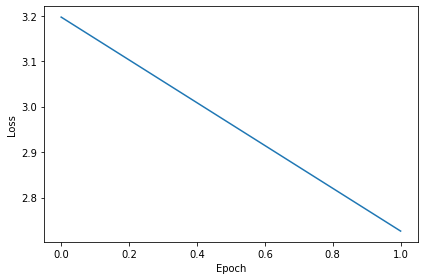

In [9]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp1_W1_trained, W1_bis, Exp1_W2_trained, Exp1_snn_training_snapshot, single_neuron_model = train(ipds_train, spikes_train,
                                                                                         multiple_connections_per_axon=False)


Train classifier accuracy: 10.0%
Train absolute error: 46.3 deg

Test classifier accuracy: 9.6%
Test absolute error: 55.7 deg


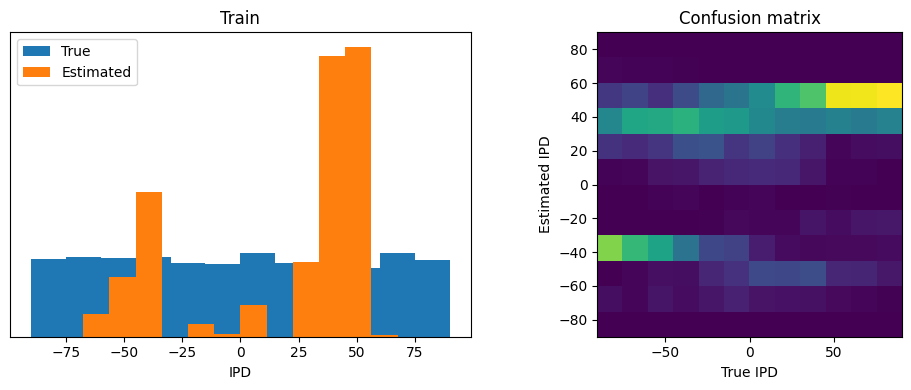

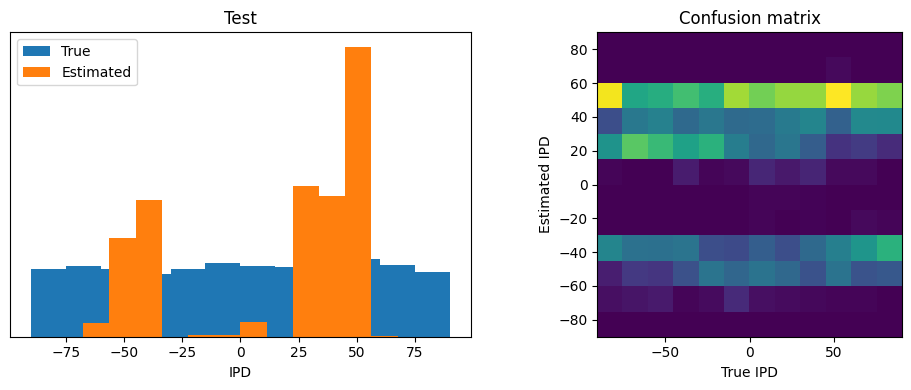

In [11]:
# training and testing accuracies
Exp1Fast_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp1_W1_trained, W1_bis, Exp1_W2_trained, 
                                           multiple_connections_per_axon=False, single_neuron_model=single_neuron_model,
                                           test_data=False)

# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp1_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp1_W1_trained, W1_bis, Exp1_W2_trained, 
                                          multiple_connections_per_axon=False, single_neuron_model=single_neuron_model,
                                          test_data=True)

## Exp 2. Training & Testing Results

### Using multiple connections (M=3)

  0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------------
EPOCH 1


 50%|█████     | 1/2 [00:08<00:08,  8.68s/it]

---EPOCH 1: LOSS=2.96387
--------------------------------------------------------
EPOCH 2


100%|██████████| 2/2 [00:16<00:00,  8.32s/it]

---EPOCH 2: LOSS=2.53749


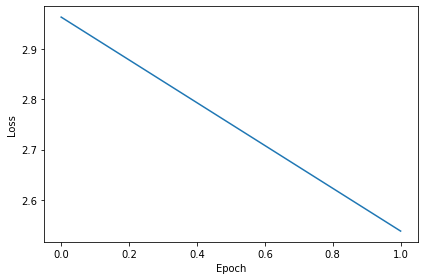

In [12]:
# training
# Generate the training data
ipds_train, spikes_train = random_ipd_input_signal(NUM_SAMPLES, usual_phase_delays=True)
Exp2_W1_trained, W1_bis, Exp2_W2_trained, Exp2_snn_training_snapshot, single_neuron_model = train(ipds_train, spikes_train,
                                                                                         multiple_connections_per_axon=True)


Train classifier accuracy: 9.2%
Train absolute error: 45.2 deg

Test classifier accuracy: 8.8%
Test absolute error: 43.7 deg


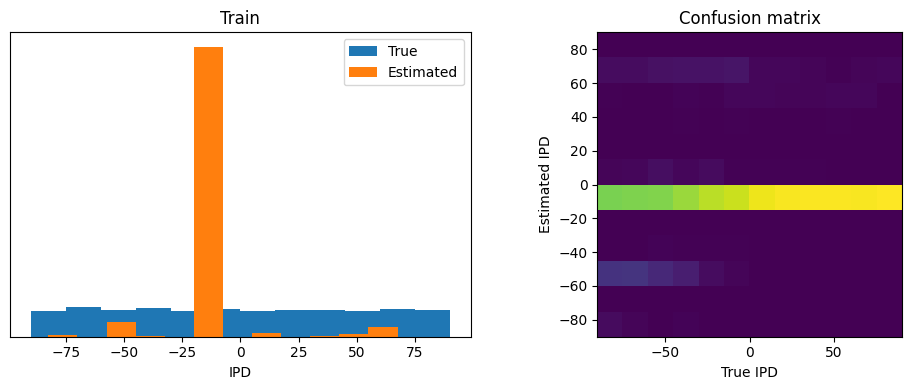

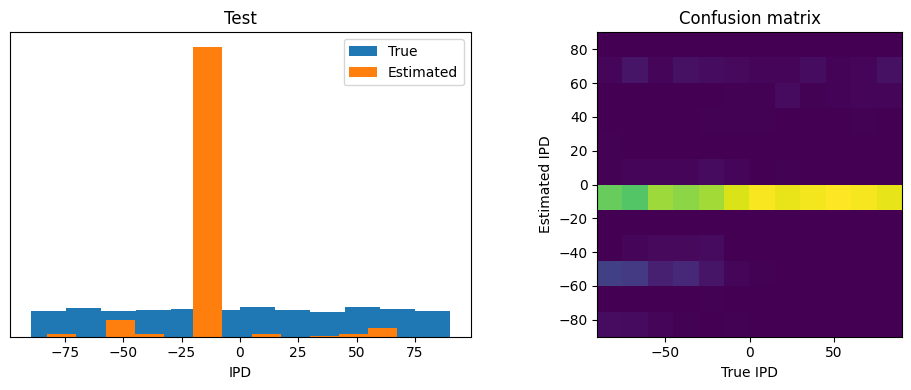

In [13]:
# training and testing accuracies
Exp2_train_accuracy = analyse_accuracy(ipds_train, spikes_train, Exp2_W1_trained, W1_bis, Exp2_W2_trained, 
                                           multiple_connections_per_axon=True, single_neuron_model=single_neuron_model,
                                           test_data=False)

# Generate the test data
ipds_test, spikes_test = random_ipd_input_signal(BATCH_SIZE*N_TESTING_BATCHES, usual_phase_delays=True)
Exp2_test_accuracy = analyse_accuracy(ipds_test, spikes_test, Exp2_W1_trained, W1_bis, Exp2_W2_trained, 
                                          multiple_connections_per_axon=True, single_neuron_model=single_neuron_model,
                                          test_data=True)